久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第5章 GLMの尤度比検定と検定の非対称性

In [1]:
using CSV
using DataFrames
using GLM
using Plots
pyplot();
using Distributions
versioninfo()

Julia Version 1.5.0
Commit 96786e22cc (2020-08-01 23:44 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)
Environment:
  JULIA_EDITOR = "C:\Users\marui\AppData\Local\Programs\Microsoft VS Code\Code.exe"
  JULIA_NUM_THREADS = 


## 5.2 尤度比検定の例題：逸脱度の差を調べる

In [2]:
d = CSV.read("data3a.csv");
fit1 = glm(@formula(y ~ 1), d, Poisson(), LogLink());
fit2 = glm(@formula(y ~ x), d, Poisson(), LogLink());

**尤度比**（_likelihood ratio_）を対数化して-2をかけたものが逸脱度の差$\Delta D$になる。
$$ \frac{L_1^\ast}{L_2^\ast} $$
$$ \Delta D_{1,2} = -2\times\left(\log L_1^\ast - \log L_2^\ast\right) $$

In [3]:
D1 = -2 * loglikelihood(fit1)
D2 = -2 * loglikelihood(fit2)
deltaD = D1 - D2   # deviance(fit1) - deviance(fit2) でも同じ

4.5139410788519285

この4.5という値の大きさが十分なのかどうかをどうやって確認するの？というのが、この後の中心的な話題。

## 5.4 帰無仮説を棄却するための有意水準

### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法（p.102）



In [4]:
deviance(fit1) - deviance(fit2)

4.513941078851829

In [5]:
d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)

100-element Array{Int64,1}:
  5
  6
 10
  8
  9
  8
  7
 10
 10
  8
  8
  9
  8
  ⋮
  5
  9
 12
 10
  5
  6
 11
 10
  5
  8
  8
  5

In [6]:
d

,y,x,f,y_rnd
,Int64,Float64,String,Int64
1,6,8.31,C,5
2,6,9.44,C,6
3,6,9.5,C,10
4,12,9.07,C,8
5,10,10.16,C,9
6,4,8.32,C,8
7,9,10.61,C,7
8,9,10.06,C,10
9,9,9.93,C,10


In [7]:
fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
deviance(fit1) - deviance(fit2)

0.44418227456145587

これを1000回くらい繰り返して、ランダム生成したデータの逸脱度の差の平均や標準偏差をみる。単純な方法は以下の`for`を使うやり方。

In [8]:
N = 1000
dd12 = zeros(N)
for n=1:N
    d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)
    fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
    fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
    dd12[n] = deviance(fit1) - deviance(fit2)
end

p.104のコードをJuliaで書くと以下のようになるだろうか。`replicate()`の代わりにarray comprehensionを使った。

In [9]:
function get_dd(d)
    n_sample = nrow(d)
    y_mean = mean(d[:y])
    d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)
    fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
    fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
    return(deviance(fit1) - deviance(fit2))
end

function pb(d, n_bootstrap)
    [get_dd(d) for n=1:n_bootstrap]
end

N = 1000
dd12 = pb(d, N)

1000-element Array{Float64,1}:
 0.0057466135306327715
 0.32222774319080827
 0.1814380153283679
 2.4935532397165616
 0.20785596463342415
 5.573545760671394
 0.8784618148608416
 0.09560259878431054
 8.199411714532076
 0.19272092857889334
 1.2497351960618488
 0.6843582073242374
 0.6529664575270857
 ⋮
 7.213000996462853
 0.026286929989069563
 0.5291438220686473
 0.5011874349989967
 0.006728681850376006
 0.23611710217029724
 0.17030491315927065
 0.12133332853197487
 0.27855594522183935
 0.33080962955386894
 0.07016497125731291
 0.00303653654411562

In [10]:
describe(dd12)

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           0.922563
Minimum:        0.000000
1st Quartile:   0.082022
Median:         0.393385
3rd Quartile:   1.198199
Maximum:        8.932181
Type:           Float64


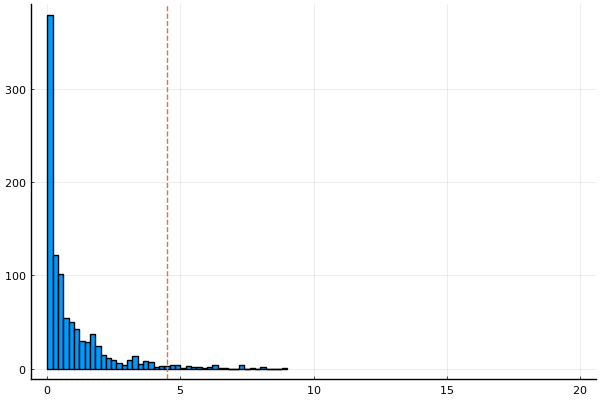

In [11]:
histogram(dd12, xlim=[0, 20], legend=false)
vline!([deltaD], linestyle=:dash)

In [12]:
sum(dd12 .>= deltaD)

35

In [13]:
p_value = sum(dd12 .>= deltaD) / length(dd12)

0.035

In [14]:
α = 0.05
quantile(dd12, 1-α)

3.6969261591158484

有意水準5%では上記の数値くらいまでの逸脱度の差は「よくある差」だと判断できる。

### 3.4.2 方法(2) カイ二乗分布を使った近似計算法

JuliaにRのようなANOVAは無さそうなので、コード例をそのままJuliaに移植することはできない。でもカイ二乗分布の累積分布関数を使ってp値を求めることはできる。

In [15]:
fit1 = glm(@formula(y ~ 1), d, Poisson(), LogLink())
fit2 = glm(@formula(y ~ x), d, Poisson(), LogLink())
dd12 = deviance(fit1) - deviance(fit2)
1 - cdf(Chisq(1), dd12)

0.03361969100898521